# DATA20001 Deep Learning - Group Project
## Image project

**Due Thursday, December 13, before 23:59.**

The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imread` from `matplotlib.pyplot`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

In [1]:
! pip install torch torchvision torchsummary sklearn

## Download the data

In [0]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
import zipfile

In [0]:
train_path = 'train'
dl_file = 'dl2018-image-proj.zip'
dl_url = 'https://users.aalto.fi/mvsjober/misc/'

zip_path = os.path.join(train_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=train_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(train_path)
    #os.unlink(zip_path)

In [4]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using GPU!


The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Your stuff goes here ...

In [0]:
import os
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random as rd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
img_path = "./train/images/"
labels_path = "./train/annotations/"

In [6]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

### Data preprocessing

In [0]:
images_path = "train/images/" 
image_files = [(images_path+f) for f in os.listdir(images_path) \
                if os.path.isfile(os.path.join(images_path, f))]
images = []
for current_img_path in image_files:
    current_img_vector =  plt.imread( current_img_path )
    filename_without_extension = os.path.basename(current_img_path)[:-4] # :-4 to drop the extension
    img_num = filename_without_extension[2:] # drop the heading "im"
    images += [img_num]
del image_files

In [0]:
images_path = "train/images/" 
image_files = [(images_path+f) for f in os.listdir(images_path) \
                if os.path.isfile(os.path.join(images_path, f))]
grayscale_images = []
colorscale_images = []
for current_img_path in image_files:
    current_img_vector =  plt.imread( current_img_path )
    if len(current_img_vector.shape)==2: # If shape is (128, 128) (no color channels)
        filename_without_extension = os.path.basename(current_img_path)[:-4] # :-4 to drop the extension
        img_num = filename_without_extension[2:] # drop the heading "im"
        grayscale_images+=[img_num]
    else:
        filename_without_extension = os.path.basename(current_img_path)[:-4] # :-4 to drop the extension
        img_num = filename_without_extension[2:] # drop the heading "im"
        colorscale_images+=[img_num]
del image_files

In [0]:
data=images
labels = [[] for _ in range(len(data))] # Empty list of labels
annotations_path = "train/annotations/"
annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
        if os.path.isfile(os.path.join(annotations_path, f))]
for file in annotations_files:
    label = os.path.basename(file)[:-4] # :-4 to drop the extension
    with open(file) as f: # file is the name of the label currently read
        img_nums = f.read().split()
    for img_num in img_nums:
        if img_num not in data:
            continue
        labels[data.index(img_num)].append(label)

In [0]:
class OneHotTransformer:
    def __init__(self):
        annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
                    if os.path.isfile(os.path.join(annotations_path, f))]
        self.vocabulary = []
        for file in annotations_files:
            label = os.path.basename(file)[:-4] # :-4 to drop the extension
            self.vocabulary.append(label)
    def toOneHot(self, labels):
        res = [0]*len(self.vocabulary)
        for i, voc in enumerate(self.vocabulary):
            if voc in labels:
                res[i] = 1
        return np.array(res)
    def toVocabulary(self, onehot):
        res = []
        for i, n in enumerate(onehot):
            if n: res.append(self.vocabulary[i])
        return res
oneHotTransformer = OneHotTransformer()

In [0]:
# Files to pytorch dataset
# Inspired from https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms
from PIL import Image

#merging_method : 
# 0 : Convert  a colored image to grey image
# 1 : Complete a grey    image with zeros   to a have colored image
# 2 : Complete a grey    image with himself to a have colored image


class imageDataset(Dataset):
    def __init__(self, data_basenames, merging_method = 2, channels = 3, height = 128, width = 128, transforms = transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
    #    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])):
        """
        data_basenames is a list of id of image, such as ["9885", "9886"]
        transforms is a list of transformation. it last element should be transforms.ToTensor()
        """
        def parse_labels(data_paths):
            """ Parse to one hot """
            labels = [[] for _ in range(len(data_paths))] # Empty list of labels
            annotations_path = "train/annotations/"
            annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
                    if os.path.isfile(os.path.join(annotations_path, f))]
            vocabulary = []
            for file in annotations_files:
                label = os.path.basename(file)[:-4] # :-4 to drop the extension
                vocabulary.append(label)
                with open(file) as f: # file is the name of the label currently read
                    img_nums = f.read().split()
                for img_num in img_nums:
                    if img_num not in data_paths:
                        continue
                    labels[data_paths.index(img_num)].append(label)
            return labels
          
        self.data = data_basenames
        self.labels = parse_labels(data_basenames)
        self.channels = channels
        self.height = height
        self.width = width
        self.transforms = transforms
        self.data_len = len(data_basenames)
        self.merging_method = merging_method

    def __getitem__(self, index):
        img_path = "train/images/im" + self.data[index] + ".jpg"
        data = Image.open(img_path)
        
        if self.transforms is not None:
            img = self.transforms(data)
        #labels = np.array(self.labels[index])
        #print(self.labels[index])
        
        if(self.merging_method == 0 ):
            
            if img.shape[0] == 3:
              img = img[0] + img[1] + img[2]
              img /= 3
              img = img.reshape((1, 128, 128))
              
        elif(self.merging_method == 1):
          
            if img.shape[0] == 1:  # change graysclae images to RGB
                zeros_torser = torch.zeros([1, 128, 128])
                img = torch.cat((img,zeros_torser, zeros_torser),0)
                
        elif(self.merging_method == 2):  
            if img.shape[0] == 1:  # change graysclae images to RGB
                img = torch.cat((img,img, img),0)
        
            
        labels = self.labels[index]
        one_hot_labels = oneHotTransformer.toOneHot(labels)
        return img, one_hot_labels

    def __len__(self):
        return self.data_len

    


In [0]:
import random
random.shuffle(images) # So we make sure test data has all kinds of label, in case
                                 # the repartition is not even according to label names

batch_size = 512

# 80% train, 20% test
index_cut =  int(len(images)*0.8)
merge_method = 2

train_dataset_orig = imageDataset(images[:index_cut], merging_method = merge_method)
train_dataset_augmentation = imageDataset(images[:index_cut],
                                       merging_method = merge_method,
                                       transforms = transforms.Compose([
                                           transforms.RandomRotation(40),
                                           transforms.ToTensor(),
                                       ])
                                      )
train_dataset_augmentation2 = imageDataset(images[:index_cut],
                                       merging_method = merge_method,
                                       transforms = transforms.Compose([
                                           transforms.RandomRotation(20),
                                           transforms.ToTensor(),
                                       ])
                                      )


train_dataset_augmentation3 = imageDataset(images[:index_cut],
                                       merging_method = merge_method,
                                       transforms = transforms.Compose([
                                           transforms.RandomCrop([128, 128]),
                                           transforms.ToTensor(),
                                       ])
                                      )

train_dataset = torch.utils.data.ConcatDataset([train_dataset_orig,
                                                train_dataset_augmentation,
                                               train_dataset_augmentation2,
                                               train_dataset_augmentation3])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_dataset = imageDataset(images[index_cut:], merging_method = merge_method)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [0]:
data, target = next(train_loader.__iter__()) # Iteration works!

tensor([[[0.7608, 0.7608, 0.7490,  ..., 0.7020, 0.7098, 0.8157],
         [0.7333, 0.7373, 0.7373,  ..., 0.7529, 0.8275, 0.7882],
         [0.7333, 0.7373, 0.7412,  ..., 0.8118, 0.7804, 0.8000],
         ...,
         [0.3765, 0.3647, 0.3961,  ..., 0.3137, 0.3020, 0.2706],
         [0.5922, 0.6078, 0.6039,  ..., 0.3176, 0.3176, 0.2588],
         [0.6235, 0.6235, 0.6314,  ..., 0.3529, 0.3608, 0.3412]],

        [[0.8196, 0.8196, 0.8157,  ..., 0.7529, 0.7608, 0.8667],
         [0.8000, 0.8039, 0.8118,  ..., 0.8039, 0.8784, 0.8431],
         [0.8039, 0.8078, 0.8118,  ..., 0.8588, 0.8353, 0.8549],
         ...,
         [0.3255, 0.3137, 0.3490,  ..., 0.3451, 0.3333, 0.3020],
         [0.4745, 0.4902, 0.4863,  ..., 0.3294, 0.3373, 0.2784],
         [0.4980, 0.4980, 0.4980,  ..., 0.3569, 0.3647, 0.3529]],

        [[0.8471, 0.8471, 0.8431,  ..., 0.7882, 0.7961, 0.9020],
         [0.8392, 0.8431, 0.8392,  ..., 0.8392, 0.9137, 0.8863],
         [0.8510, 0.8549, 0.8588,  ..., 0.9059, 0.8784, 0.

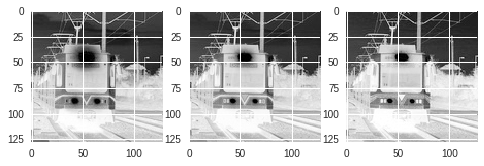

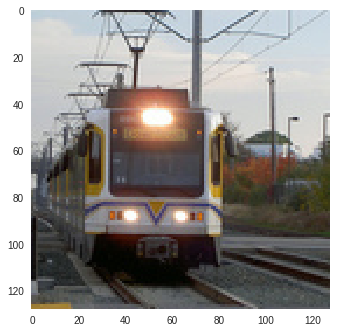

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
labels: []


In [14]:
# 3 channel show
data, target = next(train_loader.__iter__()) # Iteration works!

d0 = data[0]
print(d0)
t0 = target[0]

f, axs = plt.subplots(1,3)
axs[0].imshow(d0[0])
axs[1].imshow(d0[1])
axs[2].imshow(d0[2])
plt.show()

arr_ = d0.transpose(0,-1)
arr_ = np.rot90(arr_, 3)
arr_ = np.flip(arr_, axis=1)
plt.imshow(arr_)
plt.grid(None)
plt.show()
print(t0)
print("labels:", oneHotTransformer.toVocabulary(t0))

### Models

First, simple CNN architecture( exercise 3)

In [15]:
class sim_cnn_v1(nn.Module):
    def __init__(self, nclass = 14, input_channels=1):
        super(sim_cnn_v1,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, 16,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.fc1 = nn.Linear(30*30*32, 30*32)
        self.fc2 = nn.Linear(30*32, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        out = F.relu(self.fc1(out))
        output = self.fc2(out)
        return output
        
model = sim_cnn_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (1, 128, 128))

sim_cnn_v1(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=28800, out_features=960, bias=True)
  (fc2): Linear(in_features=960, out_features=14, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             160
       BatchNorm2d-2         [-1, 16, 126, 126]              32
              ReLU-3         [-1, 16, 126, 126]      

In [0]:
class one_layer_cnn(nn.Module):
    def __init__(self, nclass = 14, input_channels=1):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels,16,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.fc1 = nn.Linear(16*63*63, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = out.view(out.size(0),-1)
        output = self.fc1(out)
        return torch.sigmoid(output)

In [0]:
class deep_cnn(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(10, stride=3)
        )
        #self.fc1 = nn.Linear(4096, 20)
        self.lastlayer = nn.Sequential(
   #         nn.Dropout(p=0.5),
            nn.Linear(4096//64, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        #out = self.conv4(out)
        out = out.view(out.size(0),-1)
        out = self.lastlayer(out)
        return out
model = deep_cnn()

In [0]:
class deep_cnn_v2(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Sequential(
   #         nn.Dropout(p=0.5),
            nn.Linear(32, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
model = deep_cnn_v2()

In [19]:
class deep_cnn_v3(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=3)
        )
        self.fc1 = nn.Linear( 576, 32)
        self.fc2 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(32, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


model = deep_cnn_v3(input_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 128, 128))

deep_cnn_v3(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=32, bias=True)
  (fc2): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=32, out_features=14, bias=Tru

In [20]:
class deep_cnn_v4(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=7),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=7),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=7),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Sequential(
   #         nn.Dropout(p=0.5),
            nn.Linear(32, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
      
model = deep_cnn_v4(input_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 128, 128))

deep_cnn_v4(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Sequential(
    (0): Linear(in_features=32, out_features=14, bias=True)
  )
)
----------------

In [21]:
class deep_cnn_v5(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=7),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Sequential(
   #         nn.Dropout(p=0.5),
            nn.Linear(32, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
      
model = deep_cnn_v5(input_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 128, 128))

deep_cnn_v5(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Sequential(
    (0): Linear(in_features=32, out_features=14, bias=True)
  )
)
----------------

In [0]:
# TODO
class lstm(nn.Module):
    pass

### Training

In [0]:
def train_net(model, epoch, trainLoss, interval = 10):
    # set model to train
    model.train()
    loss = 0
    #acc = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.to(device) # to GPU
        target = target.float().to(device) # to GPU, ".float()" is improtant, otherwise got error.
        
        # set zero gradient buffer
        optimizer.zero_grad()
        
        # compute the output and Loss
        output = model(data)
        Loss = criterion(output, target)
        
        # back prop
        Loss.backward()
        
        # update weights
        optimizer.step()
        
        # print information
        if batch_idx % interval == 0:
            print("Train Epoch: {} [{}/{} {:.0f}%]\tLoss: {:.6f}".format(epoch, len(data)*batch_idx, len(train_loader)*len(data), batch_idx/len(train_loader)*100, Loss.data.item()))   
       
        loss += Loss
    loss/=len(train_loader)
    trainLoss.append(loss)

def validate(model, lossv, verbose=True):
  loss, acc, prec, rec = 0,0,0,0
  for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
   
    loss += criterion(output, targetv.data.to(device).float()).data.item()
  
  loss /= len(test_loader)
  
  lossv.append(loss)
  
  if verbose:
    print('Validation set: Average loss: {:.4f}\n'.format(
            loss))

In [27]:
%%time
#model = one_layer_cnn().to(device)
#model = sim_cnn_v1().to(device)
#model = lstm()
epoch = 15

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss_v1, val_loss_v1 = [], []
train_loss_v2, val_loss_v2 = [], []
train_loss_v3, val_loss_v3 = [], []
train_loss_v4, val_loss_v4 = [], []
train_loss_v5, val_loss_v5 = [], []



model_v1 = deep_cnn(input_channels=3).to(device)
optimizer = torch.optim.Adam(model_v1.parameters(), lr = learning_rate) #Adam

for i in range(1,1+epoch):
    train_net(model_v1, i, train_loss_v1)
    validate(model_v1, val_loss_v1)
    

model_v2 = deep_cnn_v2(input_channels=3).to(device)

optimizer = torch.optim.Adam(model_v2.parameters(), lr = learning_rate) #Adam


for i in range(1,1+epoch):
    train_net(model_v2, i, train_loss_v2)
    validate(model_v2, val_loss_v2)
    

model_v3 = deep_cnn_v3(input_channels=3).to(device)
optimizer = torch.optim.Adam(model_v3.parameters(), lr = learning_rate) #Adam


for i in range(1,1+epoch):
    train_net(model_v3, i, train_loss_v3)
    validate(model_v3, val_loss_v3)
    

model_v4 = deep_cnn_v4(input_channels=3).to(device)
optimizer = torch.optim.Adam(model_v4.parameters(), lr = learning_rate) #Adam

for i in range(1,1+epoch):
    train_net(model_v4, i, train_loss_v4)
    validate(model_v4, val_loss_v4)


model_v5 = deep_cnn_v5(input_channels=3).to(device)
optimizer = torch.optim.Adam(model_v5.parameters(), lr = learning_rate) #Adam
for i in range(1,1+epoch):
    train_net(model_v5, i, train_loss_v5)
    validate(model_v5, val_loss_v5)

Train Epoch: 1 [0/64000 0%]	Loss: 0.745238
Train Epoch: 1 [5120/64000 8%]	Loss: 0.673063
Train Epoch: 1 [10240/64000 16%]	Loss: 0.633232
Train Epoch: 1 [15360/64000 24%]	Loss: 0.600991
Train Epoch: 1 [20480/64000 32%]	Loss: 0.582206
Train Epoch: 1 [25600/64000 40%]	Loss: 0.561044
Train Epoch: 1 [30720/64000 48%]	Loss: 0.538608
Train Epoch: 1 [35840/64000 56%]	Loss: 0.524223
Train Epoch: 1 [40960/64000 64%]	Loss: 0.508175
Train Epoch: 1 [46080/64000 72%]	Loss: 0.495053
Train Epoch: 1 [51200/64000 80%]	Loss: 0.480957
Train Epoch: 1 [56320/64000 88%]	Loss: 0.469052
Train Epoch: 1 [61440/64000 96%]	Loss: 0.451624
Validation set: Average loss: 0.4539

Train Epoch: 2 [0/64000 0%]	Loss: 0.447045
Train Epoch: 2 [5120/64000 8%]	Loss: 0.437689
Train Epoch: 2 [10240/64000 16%]	Loss: 0.423286
Train Epoch: 2 [15360/64000 24%]	Loss: 0.413293
Train Epoch: 2 [20480/64000 32%]	Loss: 0.400042
Train Epoch: 2 [25600/64000 40%]	Loss: 0.385196
Train Epoch: 2 [30720/64000 48%]	Loss: 0.376047
Train Epoch: 2 [

In [41]:
min_val = min(val_loss_v1 + val_loss_v2 + val_loss_v3 + val_loss_v4 + val_loss_v5)

min_val in val_loss_v5

True

The best network is the network 5


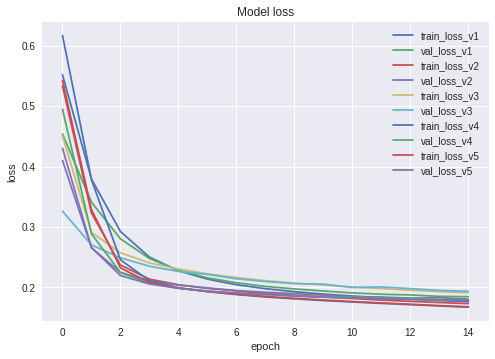

In [31]:
# The schema allows to see if the model was properly fitted
# that allows us to learn if the initial learning rate was appropriate
plt.title("Model loss")
plt.plot(train_loss_v1, label="train_loss_v1")
plt.plot(val_loss_v1, label="val_loss_v1")
plt.plot(train_loss_v2, label="train_loss_v2")
plt.plot(val_loss_v2, label="val_loss_v2")

plt.plot(train_loss_v3, label="train_loss_v3")
plt.plot(val_loss_v3, label="val_loss_v3")

plt.plot(train_loss_v4, label="train_loss_v4")
plt.plot(val_loss_v4, label="val_loss_v4")

plt.plot(train_loss_v5, label="train_loss_v5")
plt.plot(val_loss_v5, label="val_loss_v5")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

### Treshold optimization
DISCLAIMER : Does not work as intended.

In that part we strive to optimize the treshold of activation of each label, in order to maximize F1 score

In [0]:
# Concatenating all the batches _label_ output in order to not compute it several 
# times for F1 score optimization.
import sklearn.metrics
def make_pred(bounded_output_all, tresholds):
  return bounded_output_all.data.gt(tresholds) # Activation

def compute_f1(model, tresholds_as_tensor):
  f1 = 0 # Will be the average f1 over all batches (according to their sizes)
  for i, (inputv, targetv) in enumerate(test_loader):
    inputv = inputv.to(device)
    targetv = targetv.to(device)
    
    batch_size = len(inputv)
    bounded_output = torch.sigmoid(model(inputv))
    
    pred = bounded_output.data.gt(tresholds_as_tensor)
    curr_f1 = sklearn.metrics.f1_score(targetv.cpu(), pred.cpu(), average="micro") # same result
    f1 += curr_f1 * (batch_size)
  return f1/len(test_dataset)

In [49]:
#Best Threshold
tresholds = [0.3, 0.2,
             0.2, 0.2,
             0.225, 0.25,
             0.2, 0.25,
             0.225, 0.35,
             0.2, 0.3,
             0.25, 0.25
          ]
tresholds_as_tensor = torch.Tensor(tresholds).to(device)

print("Value of F1 for the model 1 : ", compute_f1(model_v1, tresholds_as_tensor))
print("Value of F1 for the model 2 : ", compute_f1(model_v2, tresholds_as_tensor))
print("Value of F1 for the model 3 : ", compute_f1(model_v3, tresholds_as_tensor))
print("Value of F1 for the model 4 : ", compute_f1(model_v4, tresholds_as_tensor))
print("Value of F1 for the model 5 : ", compute_f1(model_v5, tresholds_as_tensor))


Value of F1 for the model 1 :  0.45566272760080756
Value of F1 for the model 2 :  0.46489759035379324
Value of F1 for the model 3 :  0.43492778615495425
Value of F1 for the model 4 :  0.4697503048818567
Value of F1 for the model 5 :  0.4731189139977274
